In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from astropy.table import Table, vstack, Column
import os
import pdb
import numpy as np
import warnings
import resource
resource.setrlimit(resource.RLIMIT_NOFILE, (10000,-1))

In [2]:
path = './../spectra/'
path2 = './../catalogs/'

bigFile = Table.read('bigfile.fits')
vccfiles = []
vdgcfiles = []
vugcfiles = []
for filename in os.listdir(path):
    if ((filename.endswith(".fits")) & ("spec" in filename)):
       vdgcfiles.append(filename)
    elif ((filename.endswith(".gz")) & ("spec" in filename)):
       vugcfiles.append(filename)
    elif ((filename.endswith(".fits")) & ("VCC" in filename)):
        vccfiles.append(filename)

In [3]:
#instead get the files then do doppler shift stuff
#restFrame unecessary, just need to get the files and velocity values
restFrame = []
VUGC = []
for string in vugcfiles:
    file = fits.open(path + string)
    wavelength = file[1].data['LAMBDA']
    file.close()
    for otherFile in bigFile:
        if (string == otherFile['SPEC1DNAME']):
            velocityVal = otherFile['VOBS']
            VUGC.append(string)
            a = (wavelength * ((1)/(1+(velocityVal/(3e+5)))))
            restFrame.append(a)
            


In [4]:
#instead get the files then do doppler shift stuff
#restFrame unecessary, just need to get the files and velocity values
restFrame1 = []
VDGC = []
velocity = []
for string in vdgcfiles:
    file = fits.open(path + string)      
    wavelength = file[1].data['LAMBDA']
    file.close()
    for otherFile in bigFile:
        s = otherFile['SPEC1DNAME']
        if (string == s[:-3]):
            VDGC.append(string)
            velocityVal = otherFile['VOBS']
            velocity.append(velocityVal)
            a = (wavelength * ((1)/(1+(velocityVal/(3e+5)))))
            restFrame1.append(a)

In [5]:
warnings.simplefilter("ignore", RuntimeWarning)
def spec_interp(wv,fx,nwwv,*args):
    #Required arguments:
    #   - wv: old wavelength array
    #   - fx: flux to be rebinned, 'SPEC'
    #   - nwwv: new wavelen gth array, interval
    #
    #Optional argument: variance
    npix = len(wv)
    if len(args) == 0:
        var = np.ones(npix)
        nwvarFlag = False
    else:
        var = args[0]
        nwvarFlag = True
    nwpix = len(nwwv)
    #Calculate wavelength endpoints for each pixel
    wvl = (wv + np.roll(wv,1))/2.
    wvh = (wv + np.roll(wv,-1))/2.
    wvl[0] = wv[0] - (wv[1] - wv[0])/2.
    wvh[npix-1] = wv[npix-1] + (wv[npix-1]-wv[npix-2])/2.
    #Calculate endpoints of the final array
    bwv = np.zeros(nwpix+1)
    bwv[0:nwpix] = (nwwv+np.roll(nwwv,1))/2.
    bwv[0] = nwwv[0] - (nwwv[1] - nwwv[0])/2.
    bwv[nwpix] = nwwv[nwpix-1]+(nwwv[nwpix-1] - nwwv[nwpix - 1])/2.
    #Create tmp arrays for final array
    nwfx = np.zeros(nwpix)
    nwvar = np.zeros(nwpix)
    nwunitfx = np.zeros(nwpix)
    #Loop through the arrays
    for q in range(npix):
        #No overlap
        if (wvh[q] <= bwv[0]) | (wvl[q] >= bwv[nwpix]):
            continue
        #Find pixel that bw is within
        if wvl[q] <= bwv[0]:
            i1 = [0]
        else:
            i1 = np.argwhere((wvl[q] <= np.roll(bwv,-1)) & (wvl[q] > bwv))[0]
        if wvh[q] > bwv[nwpix]:
            i2 = [nwpix-1]
        else:
            i2 = np.argwhere((wvh[q] <= np.roll(bwv,-1)) & (wvh[q] > bwv))[0]
        j1 = i1[0]
        j2 = i2[0]
        #Now Sum up
        for kk in range(j1,j2+1):
            #Rejected pixesl do not get added in
            if var[q] > 0.:
                frac = ( np.min([wvh[q],bwv[kk+1]]) - np.max([wvl[q],bwv[kk]]) ) / (wvh[q]-wvl[q])
                nwfx[kk] = nwfx[kk]+frac*fx[q]
                nwunitfx[kk] = nwunitfx[kk]+frac*1.0
                #Variance
                if nwvarFlag:
                    if (var[q] <= 0.) | (nwvar[kk] == -1):
                       nwvar[kk] = -1
                    else:
                       nwvar[kk] = nwvar[kk]+frac*var[q]
    if nwvarFlag:
        fxOut = nwfx/nwunitfx
        varOut = nwvar*nwunitfx
        
        return fxOut,varOut
    else:
        fxOut = nwfx/nwunitfx
        return fxOut


def rebinspec(*args,**kwargs):
    #Required arguments:
    #   - wv: old wavelength array
    #   - fx: flux to be rebinned
    #   - nwwv: new wavelength array
    #
    #Optional arguments:
    #   - var = var, input and output variance
    #   - ivar = ivar, input and output ivar

    if len(args) != 3:
        print('Proper syntax is: out = rebinspec(wv, fx, nwwv, **kwargs)')
        return np.nan

    else:
        wv, fx, nwwv = args

        var = kwargs.get('var',None)
        ivar = kwargs.get('ivar',None)

        if (var is not None) & (ivar is None):
            nwfx,nwvar = spec_interp(wv,fx,nwwv,var)

            return nwfx, nwvar
        elif (var is None) & (ivar is not None):
            var = 1./ivar
            nwfx,nwvar_1 = spec_interp(wv,fx,nwwv,var)
            nwvar_1[nwvar_1 == 0.0] = -10.0
            nwivar = 1.0/nwvar_1
            nwivar[nwivar < 0.0] = 0.0
            
            return nwfx, nwivar
        else:
            nwfx = spec_interp(wv,fx,nwwv)

            return nwfx

In [15]:
def coaddition(files, velocities):
    alllambdas = []
    allfluxes = []
    allvariances = []
    for i in range(len(files)):
        f = fits.open(path + files[i])        #open file
        try:                                  #check for Bxspf blue or red, if not I resort to Horne
            tempB = f['Bxspf-' + 'B']
            tempR = f['Bxspf-' + 'R']
        except:
            tempB = f['Horne-' + 'B'] 
            tempR = f['Horne-' + 'R']
        newwaveB = tempB.data['LAMBDA']                                
        oldwaveB = newwaveB/(1 + ((velocities[i]/300000)))     #doppler shift correction
        newwaveR = tempR.data['LAMBDA']
        oldwaveR = newwaveR/(1 + ((velocities[i]/300000)))        #doppler shift correction
        alllambdas.append(np.append(oldwaveB,oldwaveR))        #this is a 1D list of blue side lambdas then red
        allfluxes.append(np.append(tempB.data['SPEC'],tempR.data['SPEC']))     #1D list of blue then red fluxes
        allvariances.append(np.append(tempB.data['IVAR'], tempR.data['IVAR']))        #1D list of blue then red variances
        f.close()     #close file
    return alllambdas, allfluxes, allvariances
RBlambdaDE, RBfluxDE, RBvarianceDE = coaddition(VDGC, velocity)           #coaddition for DE
         #coaddition for VCC

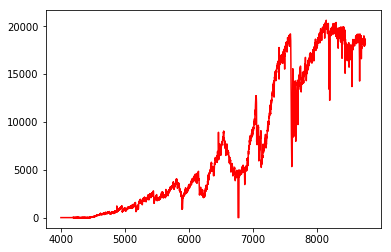

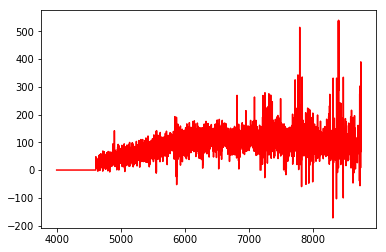

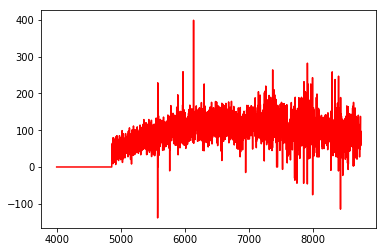

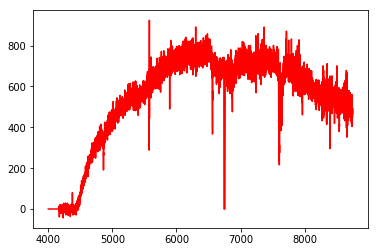

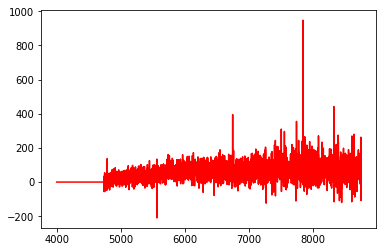

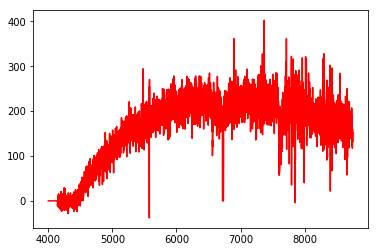

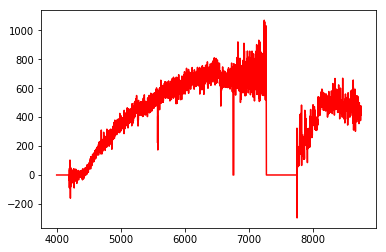

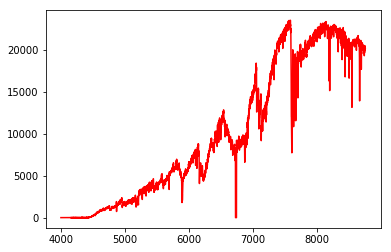

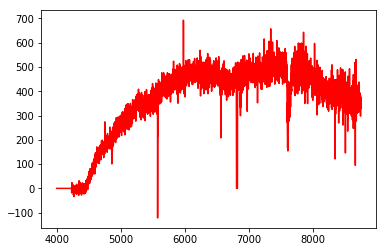

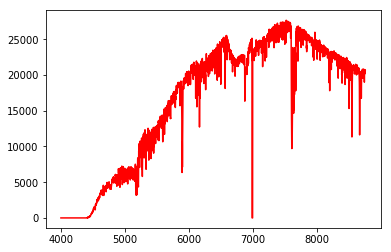

In [13]:
correct = np.arange(4000,8750.9,0.9)
for i in range (0, 10):
    newFlux, newVar = np.nan_to_num(rebinspec(RBlambdaDE[i], RBfluxDE[i], correct, ivar = RBvarianceDE[i]))
    plt.plot(correct, newFlux, color = 'red')
    plt.show()

In [ ]:
plotting(VUGC, 'UDG Spectra', restFrame, 'fuchsia')

In [ ]:
restFrame2 = []
VCC = []
for string in vccfiles:
    file = fits.open(path + string)
    wavelength = file[1].data['LAMBDA']
    file.close()
    for otherFile in bigFile:
        s = otherFile['VCC']
        if (string[:-5] == s):
            VCC.append(string)
            velocityVal = otherFile['VOBS']
            a = (wavelength * ((1)/(1+(velocityVal/(3e+5)))))
            restFrame2.append(a)

In [ ]:
plotting(VCC, 'VCC Spectra', restFrame2, 'g')


In [ ]:
def sigmaClipping(file):
    